### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

In [2]:
###### test connection ######

import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"

In [3]:
###### check environments ######

import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])

ocid1.tenancy.oc1..aaaaaaaazsst3y4ltnibxw2e56dsmdlwkc7zoshzpkst7hkgfgite4csmhoa
ocid1.datascienceproject.oc1.eu-zurich-1.amaaaaaa2jwq32iapkcl4klg3qulxmpxlgnyxwhf276mb6ukgtdhms5oc3ua
ocid1.saml2idp.oc1..aaaaaaaao4zb7iwgmzbhs3hcvl7qrob453qzrqzs3o2hhl23oczezxmtyz7q/ethlambda@gmail.com
ocid1.tenancy.oc1..aaaaaaaazsst3y4ltnibxw2e56dsmdlwkc7zoshzpkst7hkgfgite4csmhoa
eu-zurich-1


In [21]:
%%bash
###### install libs ######
#pip install matplotlib
#pip install pandas
#pip install seaborn
#pip list
#pip install scikit-learn

In [7]:
###### import libs ######

%matplotlib inline
%reload_ext autoreload
%autoreload 2

import gzip
import pickle
import logging
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator

plt.rcParams['figure.figsize'] = [10, 7]
plt.rcParams['font.size'] = 15
sns.set(color_codes=True)
sns.set(font_scale=1.5)
sns.set_palette("bright")
sns.set_style("whitegrid")

In [8]:
###### check ads env ######

ads.environment.ads_inspect.check_ads_env()

Library         Version    Required
--------------  ---------  ----------
arrow           0.14.7     0.10.0
configparser    4.0.2      3.5.0
ipykernel       5.4.0      5.1.3
pyod            0.8.1      0.7.1
pyOpenSSL       18.0.0     19.0
pytest          4.0.1      5.3.5
pytest-asyncio  0.9.0      0.10.0
six             1.14.0     1.13


In [12]:
####### load data #######

name = 'd_aea.csv'
id_col = "Id"
target_col = "ACTION"

train_name = './d_aea/train_{}'.format(name)
test_name = './d_aea/test_{}'.format(name)

df = pd.read_csv(train_name)
test_df = pd.read_csv(test_name)

print(df.head())
df.shape
#df = df.drop(['id'], axis=1)

test_df.head()
#test_df = test_df.drop(['id'], axis=1)


#df.to_csv(train_name,index=False)

#test_df.to_csv(test_name, index=False)

#print(test_df.columns)
#print(df.columns)

   ACTION  RESOURCE  MGR_ID  ROLE_ROLLUP_1  ROLE_ROLLUP_2  ROLE_DEPTNAME  \
0       1     25570   16668         117961         118300         118514   
1       1     23990    5396         117961         118343         120270   
2       1     39632   64713         120140         120141         118733   
3       1     44644    5330         117961         118052         121667   
4       1     16512   51086         117961         118343         118856   

   ROLE_TITLE  ROLE_FAMILY_DESC  ROLE_FAMILY  ROLE_CODE  
0      118777            279443       308574     118779  
1      120773            118959       118960     120774  
2      118734            255008       118736     118737  
3      118523            310608       118331     118525  
4      117905            240983       290919     117908  


,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,75078,13876,117961,118386,118404,118685,120316,308574,118687
1,1,43085,1271,117961,118327,118507,118890,138290,118398,118892
2,1,78839,795,117961,118225,120551,117905,117906,290919,117908
3,1,38725,14674,11146,118491,117920,118568,163031,19721,118570
4,1,32270,5113,117961,118300,119890,120497,258776,118424,120499


[1 0]


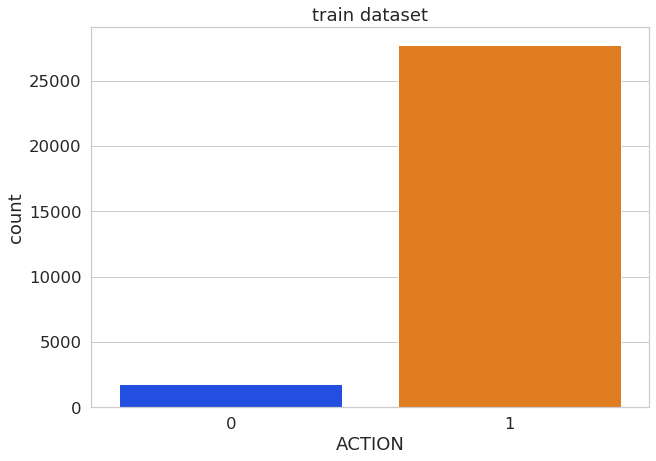

In [15]:
### dataset statistics ######
sns.countplot(x=target_col, data=df)
plt.title("train dataset")
print(df[target_col].unique())

In [17]:
###### train model ######

train = DatasetFactory.open(df).set_target(target_col)
print([train])

# create an automl job
ml_engine = OracleAutoMLProvider(n_jobs=-1, loglevel=logging.ERROR)
oracle_automl = AutoML(training_data = train, provider=ml_engine)

# time budget is in seconds
best_model, baseline = oracle_automl.train(score_metric='roc_auc', time_budget=600)

[BinaryClassificationDataset(target: ACTION) 29,492 rows, 10 columns]


Training Dataset size,"(29492, 9)"
Validation Dataset size,None
CV,5
Target variable,ACTION
Optimization Metric,roc_auc
Initial number of Features,9
Selected number of Features,9
Selected Features,"[RESOURCE, MGR_ID, ROLE_ROLLUP_1, ROLE_ROLLUP_2, ROLE_DEPTNAME, ROLE_TITLE, ROLE_FAMILY_DESC, ROLE_FAMILY, ROLE_CODE]"
Selected Algorithm,RandomForestClassifier
End-to-end Elapsed Time (seconds),616.6
Selected Hyperparameters,"{'class_weight': 'balanced_subsample', 'max_features': 0.1111111111111111, 'min_samples_leaf': 3.3907500339075e-05, 'min_samples_split': 6.781500067815e-05, 'n_estimators': 253}"


Rank based on Performance,Algorithm,#Samples,#Features,Mean Validation Score,Hyperparameters,CPU Time
2,RandomForestClassifier_HT,29492,9,0.9259,"{'class_weight': None, 'max_features': 0.1111111111111111, 'min_samples_leaf': 3.3907500339075e-05, 'min_samples_split': 6.781500067815e-05, 'n_estimators': 253}",16.8325
3,RandomForestClassifier_HT,29492,9,0.9258,"{'class_weight': None, 'max_features': 0.1111111111111111, 'min_samples_leaf': 3.3907500339075e-05, 'min_samples_split': 6.781500067815e-05, 'n_estimators': 252}",15.9579
4,RandomForestClassifier_HT,29492,9,0.9251,"{'class_weight': None, 'max_features': 0.1111111111111111, 'min_samples_leaf': 3.3907500339075e-05, 'min_samples_split': 6.781500067815e-05, 'n_estimators': 101}",6.5867
5,RandomForestClassifier_HT,29492,9,0.9251,"{'class_weight': None, 'max_features': 0.1111111111111111, 'min_samples_leaf': 3.3907500339075e-05, 'min_samples_split': 6.781500067815e-05, 'n_estimators': 100}",6.4813
6,RandomForestClassifier_HT,29492,9,0.9249,"{'class_weight': 'balanced', 'max_features': 0.1111111111111111, 'min_samples_leaf': 3.3907500339075e-05, 'min_samples_split': 6.781500067815e-05, 'n_estimators': 253}",17.0242
...,...,...,...,...,...,...
96,RandomForestClassifier_ANOVAF_FS,29492,1,0.6902,"{'n_estimators': 100, 'class_weight': 'balanced', 'max_features': 0.777777778, 'min_samples_leaf': 0.000625, 'min_samples_split': 0.00125}",4.5622
97,RandomForestClassifier_HT,29492,9,0.6868,"{'class_weight': None, 'max_features': 0.1111111111111111, 'min_samples_leaf': 3.3907500339075e-05, 'min_samples_split': 0.09392147084751533, 'n_estimators': 5}",0.2105
98,RandomForestClassifier_HT,29492,9,0.6868,"{'class_weight': None, 'max_features': 0.1111111111111111, 'min_samples_leaf': 3.3907500339075e-05, 'min_samples_split': 0.09393147016936532, 'n_estimators': 5}",0.1907
99,LogisticRegression_AS,5000,9,0.5239,"{'C': 1.0, 'class_weight': 'balanced', 'solver': 'liblinear'}",0.3317


In [28]:
###### predict test dataset ######

print(test_df.shape)

y_pred = best_model.predict(test_df)
y_true = test_df[target_col]
print(y_true.shape)

test_acc = np.mean(y_pred==y_true)
print("test accuracy = {}".format(test_acc))

import sklearn
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=1)
test_auc = metrics.auc(fpr, tpr)
print("test auc = {}".format(test_auc))

(3277, 10)
(3277,)
test accuracy = 0.9804699420201404
test auc = 0.8757104451049811


In [26]:
oracle_automl.print_trials(max_rows=129, sort_column='Mean Validation Score')

Algorithm,#Samples,#Features,Mean Validation Score,Hyperparameters,CPU Time
RandomForestClassifier_HT,29492,9,0.9261,"{'class_weight': 'balanced_subsample', 'max_features': 0.1111111111111111, 'min_samples_leaf': 3.3907500339075e-05, 'min_samples_split': 6.781500067815e-05, 'n_estimators': 253}",21.8383
RandomForestClassifier_HT,29492,9,0.9259,"{'class_weight': None, 'max_features': 0.1111111111111111, 'min_samples_leaf': 3.3907500339075e-05, 'min_samples_split': 6.781500067815e-05, 'n_estimators': 253}",16.8325
RandomForestClassifier_HT,29492,9,0.9258,"{'class_weight': None, 'max_features': 0.1111111111111111, 'min_samples_leaf': 3.3907500339075e-05, 'min_samples_split': 6.781500067815e-05, 'n_estimators': 252}",15.9579
RandomForestClassifier_HT,29492,9,0.9251,"{'class_weight': None, 'max_features': 0.1111111111111111, 'min_samples_leaf': 3.3907500339075e-05, 'min_samples_split': 6.781500067815e-05, 'n_estimators': 101}",6.5867
RandomForestClassifier_HT,29492,9,0.9251,"{'class_weight': None, 'max_features': 0.1111111111111111, 'min_samples_leaf': 3.3907500339075e-05, 'min_samples_split': 6.781500067815e-05, 'n_estimators': 100}",6.4813
RandomForestClassifier_HT,29492,9,0.9249,"{'class_weight': 'balanced', 'max_features': 0.1111111111111111, 'min_samples_leaf': 3.3907500339075e-05, 'min_samples_split': 6.781500067815e-05, 'n_estimators': 253}",17.0242
RandomForestClassifier_HT,29492,9,0.9155,"{'class_weight': 'balanced_subsample', 'max_features': 0.777777778, 'min_samples_leaf': 0.00041425204389354867, 'min_samples_split': 0.00125, 'n_estimators': 253}",54.0380
RandomForestClassifier_HT,29492,9,0.9138,"{'class_weight': 'balanced', 'max_features': 0.777777778, 'min_samples_leaf': 0.00041425204389354867, 'min_samples_split': 0.0012599993218499932, 'n_estimators': 100}",19.4435
RandomForestClassifier_HT,29492,9,0.9138,"{'class_weight': 'balanced', 'max_features': 0.777777778, 'min_samples_leaf': 0.00041925170481854526, 'min_samples_split': 0.00125, 'n_estimators': 100}",19.5491
RandomForestClassifier_HT,29492,9,0.9138,"{'class_weight': 'balanced', 'max_features': 0.777777778, 'min_samples_leaf': 0.00041425204389354867, 'min_samples_split': 0.00125, 'n_estimators': 100}",19.4114


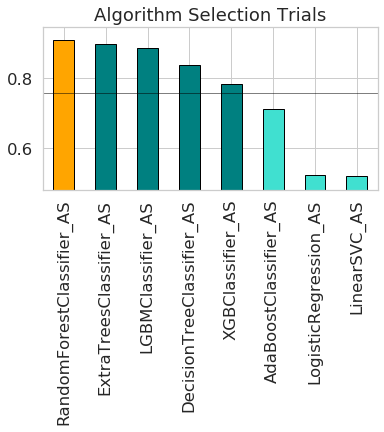

In [25]:
oracle_automl.visualize_algorithm_selection_trials()

In [43]:
###### load kaggle test dataset ######
kaggle_test_name = './d_aea/kaggle-test_{}'.format(name)

kaggle_test_df = pd.read_csv(kaggle_test_name)
kaggle_test_id = np.array(kaggle_test_df[id_col])
kaggle_test_df = kaggle_test_df.drop([id_col], axis=1)

print(kaggle_test_df.head())
kaggle_test_df.shape

FileNotFoundError: [Errno 2] File b'./d_aea/kaggle-test_d_aea.csv.csv' does not exist: b'./d_aea/kaggle-test_d_aea.csv.csv'

In [40]:
###### predict kaggle test dataset ######

kaggle_y_pred = best_model.predict(kaggle_test_df)

assert kaggle_y_pred.shape == kaggle_test_id.shape

print(kaggle_y_pred.shape)
print(kaggle_y_pred[:100])

(58921,)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1]


In [44]:
###### save kaggle prediction ######

kaggle_pred_name = './d_aea/kaggle-test_{}_predictions.csv'.format(name)

kaggle_pred_df = pd.DataFrame({id_col: kaggle_test_id, target_col: kaggle_y_pred})
print(kaggle_pred_df.head())

kaggle_pred_df.to_csv(kaggle_pred_name, index=False)

   Id  ACTION
0   1       1
1   2       1
2   3       1
3   4       1
4   5       1
